### This notebook generates the precipitation efficiency distribution for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy.stats import pearsonr, zscore
from scipy.integrate import trapz
from matplotlib import cm
from numpy import unravel_index
from matplotlib.gridspec import GridSpec
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Load ERA-I data

In [8]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
omega_array = nc_open_compile(file_years,"omega",'stack')
pmax_array = nc_open_compile(file_years,"pmax")

tropical_up_indx = np.argwhere( (np.all(omega_array < 0, axis=1)) & (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) &
                                  (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
print(tropical_up_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_rain_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_rain_indx]
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_rain_indx]
omega_ERAI = positive_to_nan(omega_array)[tropical_rain_indx]

(29293,)
(124047,)


In [9]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
# In this calculation, I do not yet filter for tropical lat/lon. That is done below.
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_rain_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [10]:
# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_rain_indx]
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)[tropical_rain_indx]

i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*100
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3

### Precipitation efficiency from integrated condensation rate scaling

In [11]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
dqvsat_dp_ERAI = np.gradient( qvsat_ERAI, plev_ERAI, axis=1 )
print(dqvsat_dp_ERAI.shape)

# Multiply the gradient with respect to pressure by pressure velocity
integrand = omega_ERAI * dqvsat_dp_ERAI / g

# Determine integration bounds on the basis of the cold-point tropopause
tempmean_ERAI = np.nanmean( temp_ERAI, axis=0 )

# Integrate the condensation rate over the pressures
cond_rate_ERAI = np.trapz( x=plev_ERAI, y=-1.*integrand )
print( np.nanmin(cond_rate_ERAI), np.nanmedian(cond_rate_ERAI), np.nanmean(cond_rate_ERAI), np.nanmax(cond_rate_ERAI) )
peff_ERAI = pmax_ERAI / 3600 / cond_rate_ERAI
print( np.nanmin(peff_ERAI), np.nanmedian(peff_ERAI), np.nanmax(peff_ERAI) )

(124047, 32)
2.6988556416260292e-05 0.0002665927177509372 0.00029609113686572357 0.011055913955453136
0.8129845978695237 15.119544046537127 377.06746197884456


## Filter by MCS morphology

In [12]:
# Storm morphology parameters - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_rain_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_rain_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_rain_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_rain_indx]

### Calculate LWP and IWP

In [15]:
# Integrated amounts of cloud condensate - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
qi_array = nc_open_compile(file_years,"qi","stack")
qi_ERAI = negative_to_nan(qi_array)[tropical_rain_indx]

# This method of evaluating IWP omits instances in which there is a NaN sandwiched between numeric values.
# But these instances only constitute 3% of all samples.
IWP_ERAI = np.zeros( (qi_ERAI.shape[0],) )
for i in np.arange(qi_ERAI.shape[0]):
    j = np.argwhere( ~np.isnan(qi_ERAI[i]) )
    if len( j ) > 0:
        start = j[0][0]
        end = j[-1][0]
        IWP_ERAI[i] = np.trapz( qi_ERAI[i,start:end] / g, plev_ERAI[start:end] )*1000 # [g m-2]
    else:
        continue

In [17]:
qc_array = nc_open_compile(file_years,"qc","stack")
qc_ERAI = negative_to_nan(qc_array)[tropical_rain_indx]

# This method of evaluating LWP omits instances in which there is a NaN sandwiched between numeric values.
# But these instances only constitute 3% of all samples.
LWP_ERAI = np.zeros( (qc_ERAI.shape[0],) )
for i in np.arange(qc_ERAI.shape[0]):
    j = np.argwhere( ~np.isnan(qc_ERAI[i]) )
    if len( j ) > 0:
        start = j[0][0]
        end = j[-1][0]
        LWP_ERAI[i] = np.trapz( qc_ERAI[i,start:end] / g, plev_ERAI[start:end] )*1000 # [g m-2]
    else:
        continue

In [18]:
print('Statistics of precipitation efficiency:')
print(np.percentile( peff_ERAI, 99 ))
print(np.nanmax( peff_ERAI ))
print(np.nanmedian( peff_ERAI))
print(np.nanmean( peff_ERAI))

Statistics of precipitation efficiency:
nan
377.06746197884456
15.119544046537127
19.994106370209543


In [20]:
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )
condensate_ERAI = qc_ERAI + qi_ERAI
condensate_small = qc_ERAI[rad_ERAI <= loo,:] + qi_ERAI[rad_ERAI <= loo,:]
condensate_large = qc_ERAI[rad_ERAI >= upp,:] + qi_ERAI[rad_ERAI >= upp,:]

CWP_ERAI = LWP_ERAI + IWP_ERAI
CWP_small = LWP_ERAI[rad_ERAI <= loo] + IWP_ERAI[rad_ERAI <= loo]
CWP_large = LWP_ERAI[rad_ERAI >= upp] + IWP_ERAI[rad_ERAI >= upp]
print(np.nanmean(CWP_ERAI),np.nanmean(CWP_small),np.nanmean(CWP_large))
print( (np.nanmean(CWP_small)-np.nanmean(CWP_large))/np.nanmean(CWP_large) )

174.53184553652622 192.825023012292 152.31325427339257
0.2659766474832413


In [21]:
# Are the precipitation efficiency distributions statistically significant for small versus large MCSs?
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )
data1 = peff_ERAI
data2 = peff_ERAI[rad_ERAI >= upp]
data3 = peff_ERAI[rad_ERAI <= loo]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

0.022568960748040684 2.055227953215943e-11
0.04107829511938273 5.3712182430467974e-24
0.01866548728869881 2.2132579719285316e-08


In [22]:
# Are the CWP distributions statistically significant for small versus large MCSs?
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )
data1 = CWP_ERAI
data2 = CWP_ERAI[rad_ERAI >= upp]
data3 = CWP_ERAI[rad_ERAI <= loo]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

0.04681364675163352 1.0500150644629292e-47
0.07942951264770592 1.2682339666979424e-88
0.033769095295697105 1.834531211970609e-26


In [26]:
print( (np.nanmean(condensate_small,axis=0)-np.nanmean(condensate_large,axis=0))/np.nanmean(condensate_small,axis=0) )
print( plev_ERAI[-18] )

[ 0.2116744   0.20601289  0.17478429  0.17313715  0.2115414   0.25859785
  0.30574311  0.32424827  0.31907862  0.28811293  0.28069989  0.29673124
  0.29128259  0.25175132  0.195792    0.22067677  0.2289896   0.21334179
  0.18930144  0.20056708  0.17690119  0.13916395  0.14014285  0.13612603
  0.10179552  0.12302292  0.14247345  0.14357683  0.11061886  0.10456572
  0.0848681  -0.03228656]
55797.3388671875


## Plot distributions of precipitation efficiency, CWP, and cloud condensate

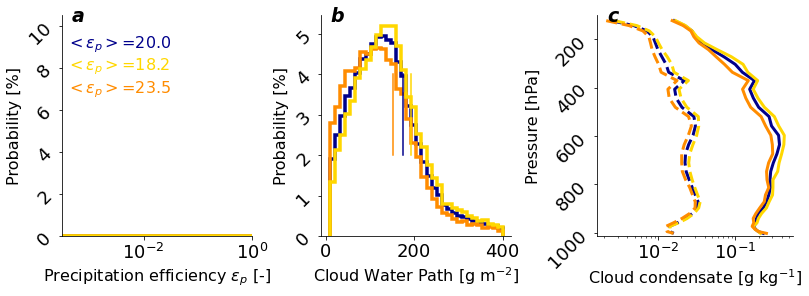

In [23]:
fig = plt.figure( figsize =(11, 4), constrained_layout=True )
lw = 3.5
fs = 16
gs = GridSpec(1, 100, figure=fig)
xlab = [ r'Precipitation efficiency $\varepsilon_p$ [-]', r'Cloud Water Path [g m$^{-2}$]', r'Cloud condensate [g kg$^{-1}$]' ]

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
edges, h = np.histogram( peff_ERAI, weights=wgts, bins=np.logspace(-3.5,0,35) )

# stratifying by extent
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )
wgts2 = np.ones_like( peff_ERAI[rad_ERAI >= upp] )/float( len( peff_ERAI[rad_ERAI >= upp] ) )*100
edges2, h2 = np.histogram( peff_ERAI[rad_ERAI >= upp], weights=wgts2, bins=np.logspace(-3.5,0,35) )
wgts3 = np.ones_like( peff_ERAI[rad_ERAI <= loo] )/float( len( peff_ERAI[rad_ERAI <= loo] ) )*100
edges3, h3 = np.histogram( peff_ERAI[rad_ERAI <= loo], weights=wgts3, bins=np.logspace(-3.5,0,35) )
#print(h2)
#print('~~~~~~~~~~~~~~~')
#print(edges2)
#print('~~~~~~~~~~~~~~~')
#print(edges3)

ax1 = fig.add_subplot(gs[0,:33])
ax1.stairs( edges, h, edgecolor='darkblue', lw=lw )
ax1.stairs( edges2, h2, edgecolor='darkorange', lw=lw )
ax1.stairs( edges3, h3, edgecolor='gold', lw=lw )
ax1.plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [2.5,5], color='darkblue', lw=lw )
ax1.plot( [np.nanmean(peff_ERAI[rad_ERAI>=upp]), np.nanmean(peff_ERAI[rad_ERAI>=upp])], [2.5,5], lw=lw, color='darkorange' )
ax1.plot( [np.nanmean(peff_ERAI[rad_ERAI<=loo]), np.nanmean(peff_ERAI[rad_ERAI<=loo])], [2.5,5], lw=lw, color='gold' )
ax1.text( 0.05, 0.97, 'a', weight='bold', style='italic', fontsize=fs+3, transform=ax1.transAxes )
ax1.set_ylabel( 'Probability [%]', fontsize=fs )
ax1.text( 0.02, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI):.3}", color='darkblue', fontsize=fs, transform=ax1.transAxes)
ax1.text( 0.02, 0.75, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[rad_ERAI<=loo]):.3}", color='gold', fontsize=fs, transform=ax1.transAxes)
ax1.text( 0.02, 0.65, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[rad_ERAI>=upp]):.3}", color='darkorange', fontsize=fs, transform=ax1.transAxes)
ax1.set_xlim([10**(-3.5),1])
ax1.set_xticks([10**(-3), 10**(-2), 10**(-1), 1])
ax1.set_xticklabels([r'10$^{-3}$', r'10$^{-2}$', r'10$^{-1}$', '1'])
ax1.set_xscale( 'log' )
ax1.set_ylim([0,10.5])

ax2 = fig.add_subplot(gs[0,33:66])
wgts = np.ones_like( CWP_ERAI )/float( len( CWP_ERAI) )*100
edges, h = np.histogram( CWP_ERAI, weights=wgts, bins=np.linspace(10,400,35) )
wgts2 = np.ones_like( CWP_large )/float( len(CWP_large) )*100
edges2, h2 = np.histogram( CWP_large, weights=wgts2, bins=np.linspace(10,400,35) )
wgts3 = np.ones_like( CWP_small )/float( len(CWP_small) )*100
edges3, h3 = np.histogram( CWP_small, weights=wgts3, bins=np.linspace(10,400,35) )

ax2.stairs( edges, h, edgecolor='darkblue', lw=lw )
ax2.stairs( edges2, h2, edgecolor='darkorange', lw=lw )
ax2.stairs( edges3, h3, edgecolor='gold', lw=lw )
ax2.plot( [np.nanmean(CWP_ERAI), np.nanmean(CWP_ERAI)], [2,4], color='darkblue', lw=lw-2 )
ax2.plot( [np.nanmean(CWP_large), np.nanmean(CWP_large)], [2,4], color='darkorange', lw=lw-2 )
ax2.plot( [np.nanmean(CWP_small), np.nanmean(CWP_small)], [2,4], color='gold', lw=lw-2 )
ax2.set_ylabel( 'Probability [%]', fontsize=fs )
ax2.text( 0.05, 0.97, 'b', weight='bold', style='italic', fontsize=fs+3, transform=ax2.transAxes )

ax3 = fig.add_subplot(gs[0,66:])
ax3.set_ylim( [1013,100] )
ax3.plot( (np.nanmean(condensate_ERAI,axis=0) )*1000, plev_ERAI/100., color='darkblue', lw=3, ls='--' )
ax3.plot( (np.nanmean(condensate_small,axis=0) )*1000, plev_ERAI/100., color='gold', lw=3, ls='--' )
ax3.plot( (np.nanmean(condensate_large,axis=0) )*1000, plev_ERAI/100., color='darkorange', lw=3, ls='--' )
ax3.plot( (np.nanpercentile(condensate_ERAI,99,axis=0) )*1000, plev_ERAI/100., color='darkblue', lw=3 )
ax3.plot( (np.nanpercentile(condensate_small,99,axis=0) )*1000, plev_ERAI/100., color='gold', lw=3 )
ax3.plot( (np.nanpercentile(condensate_large,99,axis=0) )*1000, plev_ERAI/100., color='darkorange', lw=3 )
ax3.text( 0.05, 0.97, 'c', weight='bold', style='italic', fontsize=fs+3, transform=ax3.transAxes )
ax3.set_xscale( 'log' )
ax3.set_ylabel( 'Pressure [hPa]', fontsize=fs )

for i, a in enumerate([ax1, ax2, ax3]):
    a.set_xlabel( xlab[i], fontsize=fs )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-ERAI.pdf', bbox_inches='tight' )
plt.show()

### filtering precipitation efficiency for different morphological parameters and intensities

In [103]:
omega_array = nc_open_compile(file_years,"omega",'stack')
pmax_array = nc_open_compile(file_years,"pmax")
indx1 = np.argwhere( (pmax_array >= np.percentile(pmax_array,75)) & (np.all(omega_array < 0, axis=1)) &
                                (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
indx2 = np.argwhere( (pmax_array >= np.percentile(pmax_array,90)) & (np.all(omega_array < 0, axis=1)) &
                                (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
peff_other = [[] for i in np.arange(2)]
for j, i in enumerate([indx1, indx2]):
    T = nc_open_compile( file_years, "temperature", 'stack' )[i]
    qvsat = eps * satVapP_liq(T) / ( plev_ERAI - satVapP_liq(T) )
    dqvsat_dp = np.gradient( qvsat, p_ERAI, axis=1 )
    omega = nc_open_compile(file_years,"omega",'stack')[i]
    integrand = 100*omega * dqvsat_dp / g
    Tmean = np.nanmean( T, axis=0 )
    cond_rate = np.trapz( x=p_ERAI[:-1], y=-1.*integrand[:,:-1] )
    pmax = pmax_array[i]
    peff_other[j].extend( pmax / 3600 / cond_rate )

[0.01515381 0.01515381 0.01515381 ... 0.01515381 0.01515381 0.01515381]


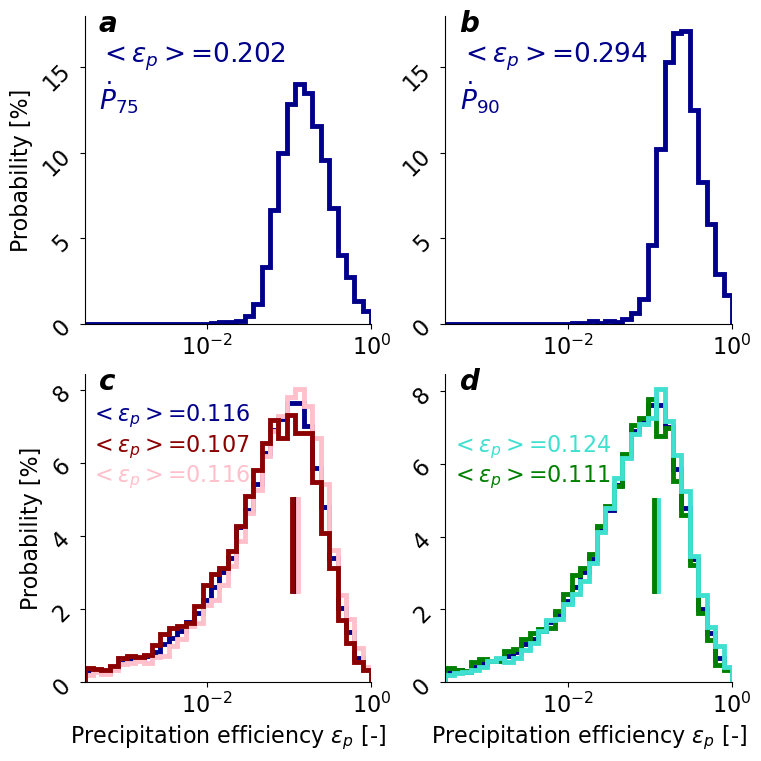

In [119]:
fig, ax = plt.subplots( nrows=2, ncols=2, figsize =(7.5, 7.5), constrained_layout=True )

wgts = np.ones_like( peff_other[0] )/float( len( peff_other[0] ) )*100
edges, h = np.histogram( np.array(peff_other[0]), weights=wgts, bins=np.logspace(-3.5,0,35) )
ax[0,0].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[0,0].text( 0.05, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_other[0]):.3}", color='darkblue', fontsize=fs+3, transform=ax[0,0].transAxes)
ax[0,0].text( 0.05, 0.7, r"$\dot{P}_{75}$", color='darkblue', fontsize=fs+3, transform=ax[0,0].transAxes )
ax[0,0].set_ylim( [0,18])
ax[0,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0,0].text( 0.05, 0.95, 'a', weight='bold', fontsize=fs+4, style='italic', transform=ax[0,0].transAxes )

wgts = np.ones_like( peff_other[1] )/float( len( peff_other[1] ) )*100
print(wgts)
edges, h = np.histogram( np.array(peff_other[1]), weights=wgts, bins=np.logspace(-3.5,0,35) )
ax[0,1].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[0,1].set_ylim( [0,18])
ax[0,1].text( 0.05, 0.95, 'b', weight='bold', fontsize=fs+4, style='italic', transform=ax[0,1].transAxes )
ax[0,1].text( 0.05, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_other[1]):.3}", color='darkblue', fontsize=fs+3, transform=ax[0,1].transAxes)
ax[0,1].text( 0.05, 0.7, r"$\dot{P}_{90}$", color='darkblue', fontsize=fs+3, transform=ax[0,1].transAxes )

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
edges, h = np.histogram( peff_ERAI, weights=wgts, bins=np.logspace(-3.5,0,35) )
loo = np.percentile( lifetime_ERAI, 25 )
upp = np.percentile( lifetime_ERAI, 75 )
wgts6 = np.ones_like( peff_ERAI[lifetime_ERAI >= upp] )/float( len( peff_ERAI[lifetime_ERAI >= upp] ) )*100
edges6, h6 = np.histogram( peff_ERAI[lifetime_ERAI >= upp], weights=wgts6, bins=np.logspace(-3.5,0,35) )
wgts7 = np.ones_like( peff_ERAI[lifetime_ERAI <= loo] )/float( len( peff_ERAI[lifetime_ERAI <= loo] ) )*100
edges7, h7 = np.histogram( peff_ERAI[lifetime_ERAI <= loo], weights=wgts7, bins=np.logspace(-3.5,0,35) )

ax[1,0].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[1,0].stairs( edges6, h6, edgecolor='pink', lw=lw )
ax[1,0].stairs( edges7, h7, edgecolor='darkred', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [2.5,5], color='darkblue', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERAI[lifetime_ERAI>=upp]), np.nanmean(peff_ERAI[lifetime_ERAI>=upp])], [2.5,5], color='pink', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERAI[lifetime_ERAI<=loo]), np.nanmean(peff_ERAI[lifetime_ERAI<=loo])], [2.5,5], color='darkred', lw=lw )
ax[1,0].text( 0.02, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI):.3}", color='darkblue', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.02, 0.75, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[lifetime_ERAI<=loo]):.3}", color='darkred', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.02, 0.65, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[rad_ERAI>=upp]):.3}", color='pink', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.05, 0.95, 'c', weight='bold', fontsize=fs+4, style='italic', transform=ax[1,0].transAxes )
ax[1,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[1,0].set_xlabel( r'Precipitation efficiency $\varepsilon_p$ [-]', fontsize=fs )

loo = np.percentile( minctt_ERAI, 25 )
upp = np.percentile( minctt_ERAI, 75 )
wgts4 = np.ones_like( peff_ERAI[minctt_ERAI >= upp] )/float( len( peff_ERAI[minctt_ERAI >= upp] ) )*100
edges4, h4 = np.histogram( peff_ERAI[minctt_ERAI >= upp], weights=wgts4, bins=np.logspace(-3.5,0,35) )
wgts5 = np.ones_like( peff_ERAI[minctt_ERAI <= loo] )/float( len( peff_ERAI[minctt_ERAI <= loo] ) )*100
edges5, h5 = np.histogram( peff_ERAI[minctt_ERAI <= loo], weights=wgts5, bins=np.logspace(-3.5,0,35) )

ax[1,1].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[1,1].stairs( edges4, h4, edgecolor='green', lw=lw )
ax[1,1].stairs( edges5, h5, edgecolor='turquoise', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERAI), np.nanmean(peff_ERAI)], [2.5,5], color='darkblue', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERAI[minctt_ERAI<=loo]), np.nanmean(peff_ERAI[minctt_ERAI<=loo])], [2.5,5], color='turquoise', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERAI[minctt_ERAI>=upp]), np.nanmean(peff_ERAI[minctt_ERAI>=upp])], [2.5,5], color='green', lw=lw )
ax[1,1].text( 0.02, 0.75, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[minctt_ERAI<=loo]):.3}", color='turquoise', fontsize=fs, transform=ax[1,1].transAxes)
ax[1,1].text( 0.02, 0.65, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERAI[minctt_ERAI>=upp]):.3}", color='green', fontsize=fs, transform=ax[1,1].transAxes)
ax[1,1].text( 0.05, 0.95, 'd', weight='bold', fontsize=fs+4, style='italic', transform=ax[1,1].transAxes )
ax[1,1].set_xlabel( r'Precipitation efficiency $\varepsilon_p$ [-]', fontsize=fs )

for a in ax.flatten():
    a.set_xscale( 'log' )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim([10**(-3.5),1])

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/S6-precipeff-others.pdf', bbox_inches='tight' )
plt.show()

## Calculate correlations of precipitation efficiency with different conditions

In [14]:
# Thermodynamic parameters - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERAI = negative_to_nan(t2m_array)[tropical_up_indx]
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERAI = negative_to_nan(dpt_array)[tropical_up_indx]
sst_array = nc_open_compile(file_years,"sst")
sst_ERAI = negative_to_nan(sst_array)[tropical_up_indx]

In [15]:
# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_up_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_up_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_up_indx]
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERAI = positive_to_nan(omega_array)[tropical_up_indx]
#omegaint_ERAI = np.cumsum( rho*w_ERAI, axis=1 )*1000 # [g m-2]
#print(omegaint_ERAI.shape)
#omegaint_ERAI = omegaint_ERAI[:,-1]
#print(omegaint_ERAI.shape)

In [120]:
print('Correlation of precip efficiency with storm morphology parameters')
for var in [ rad_ERAI, maxrad_ERAI, ctt_ERAI, minctt_ERAI, lifetime_ERAI ]:
    print( pe_cc( var, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with LWP versus IWP')
for var in [ LWP_ERAI, IWP_ERAI ]:
    print( pe_cc( var, peff_ERAI) )
    
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
for var in [ t2m_ERAI, sst_ERAI, dpt_ERAI ]:
    print( pe_cc( var, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE')
for var in [ cape_ERAI, capepre_ERAI, capepre6_ERAI ]:
    print( pe_cc( np.sqrt(var), peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with SD')
for var in [ sd_ERAI, sdpre_ERAI ]:
    print( pe_cc( var, peff_ERAI) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with qc/qi at different levels')
for j in np.arange( 10, 32 ):
    print( plev_ERAI[j], pe_cc( qc_ERAI[:,j], peff_ERAI ) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with omega at different levels')
for j in np.arange( 10, 32 ):
    print( plev_ERAI[j], pe_cc( -1.*omega_ERAI[:,j], peff_ERAI ) )


Correlation of precip efficiency with storm morphology parameters
(0.14375467306347212, 2.360158939359827e-128)
(0.0651042685157914, 3.530743736696998e-27)
(0.0574094156690236, 1.3439981637056307e-22)
(-0.0336623976425557, 1.2822349005831719e-08)
(0.03936595657852139, 4.078378120417973e-11)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with LWP versus IWP
(0.043030777804594515, 3.467525023297834e-13)
(0.02472226615206962, 2.624388599517965e-05)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
(-0.025177558345937743, 1.8595280400510198e-05)
(0.012481061625921122, 0.07019295558502237)
(0.04404085883147206, 6.270793233765703e-14)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE
(0.01636898226480419, 0.011622303716186463)
(0.009608324567587676, 0.15499328994228562)
(-0.002585880409806865, 0.6939559064354525)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip